In [1]:
import sys, os, time, json, pickle
from timeit import default_timer as timer
from humanfriendly import format_timespan
from glob import glob

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
from dotenv import load_dotenv
# load_dotenv('admin.env')
load_dotenv('../admin.env')

True

In [5]:
from mysql_connect import get_db_connection
db = get_db_connection('jp_autoreview')

In [39]:
start = timer()
df = db.read_sql(db.tables['pipeline_tests'].select())
print(format_timespan(timer()-start))

4.1 seconds


In [40]:
df.set_index('id', inplace=True)

In [41]:
top_results = df.sort_values('score_correctly_predicted', ascending=False).drop_duplicates(['review_paper_id', 'random_seed'])

In [42]:
# limit to at least 20 target papers
top_results = top_results[top_results.num_target_papers>=20]

In [43]:
top_results.mean().apply(lambda x: format(x, 'f'))

review_paper_id              2098909654.929733
random_seed                           2.998773
num_correctly_predicted             242.833998
num_target_papers                   853.112918
num_target_in_candidates            841.709727
num_seed_papers                      50.000000
score_correctly_predicted             0.295800
num_candidates                   551742.496778
time_fit                           1739.139920
time_predict                        793.613071
dtype: object

In [44]:
top_results.score_correctly_predicted.describe()

count    3259.000000
mean        0.295800
std         0.109889
min         0.004098
25%         0.218888
50%         0.297101
75%         0.364045
max         0.759615
Name: score_correctly_predicted, dtype: float64

In [45]:
top_results[top_results.num_target_papers>=20]['score_correctly_predicted'].describe()

count    3259.000000
mean        0.295800
std         0.109889
min         0.004098
25%         0.218888
50%         0.297101
75%         0.364045
max         0.759615
Name: score_correctly_predicted, dtype: float64

In [46]:
top_results[top_results.num_target_papers>=20]['score_correctly_predicted'].describe()

count    3259.000000
mean        0.295800
std         0.109889
min         0.004098
25%         0.218888
50%         0.297101
75%         0.364045
max         0.759615
Name: score_correctly_predicted, dtype: float64

In [47]:
top_results.review_paper_id.nunique()

654

In [48]:
top_results[top_results.score_correctly_predicted>.68].sort_values('score_correctly_predicted', ascending=False).drop_duplicates(subset=['review_paper_id'])

,datetime_added,review_paper_id,random_seed,datadir,num_correctly_predicted,num_target_papers,num_target_in_candidates,num_seed_papers,score_correctly_predicted,num_candidates,features,clf,clf_type,time_fit,time_predict,saved_model
id,,,,,,,,,,,,,,,,
90602,2018-07-07 04:42:46,2071171979,5,data/review_2071171979/seed_005,79,104,103,50,0.759615,12698,"['avg_distance_to_train', 'ef', 'avg_title_tfi...","RandomForestClassifier(bootstrap=True, class_w...",RandomForestClassifier,25,15,data/review_2071171979/seed_005/best_model_201...
42194,2018-06-26 23:22:32,783250631,2,data/review_783250631/seed_002,292,413,404,50,0.707022,640600,"['avg_distance_to_train', 'ef', 'avg_title_tfi...","RandomForestClassifier(bootstrap=True, class_w...",RandomForestClassifier,1485,1341,data/review_783250631/seed_002/best_model_2018...
72154,2018-07-03 04:55:32,2026986848,1,data/review_2026986848/seed_001,18,26,24,50,0.692308,427772,"['avg_distance_to_train', 'ef', 'avg_title_tfi...","RandomForestClassifier(bootstrap=True, class_w...",RandomForestClassifier,518,492,None


In [49]:
import seaborn as sns

In [97]:
# take out review papers that don't have 5 classifiers trained
num_models_per_paper = top_results.groupby('review_paper_id')['random_seed'].count().sort_values()
exclude = num_models_per_paper[num_models_per_paper<5]
print("removing {} review papers with <5 classifiers".format(len(exclude)))
top_results = top_results[~(top_results.review_paper_id.isin(exclude.index))]

removing 6 review papers with <5 classifiers


In [98]:
top_results.shape

(3240, 31)

In [99]:
top_results.review_paper_id.nunique()

648

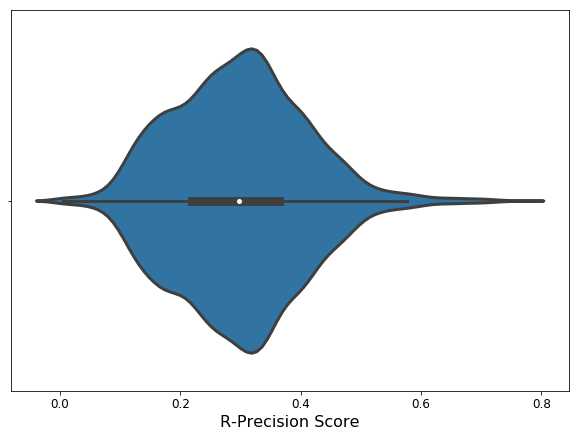

In [242]:
fig, ax = plt.subplots(figsize=(10,7))
sns.violinplot(x=top_results.score_correctly_predicted, ax=ax, linewidth=3)
ax.set_xlabel('R-Precision Score', size=16)
ax.tick_params(labelsize=12)

In [243]:
# fig.savefig('score_correctly_predicted_violinplot_20190927.png')

In [101]:
top_results[top_results.num_target_papers>=20].sort_values('num_target_in_candidates')

,datetime_added,review_paper_id,random_seed,datadir,num_correctly_predicted,num_target_papers,num_target_in_candidates,num_seed_papers,score_correctly_predicted,num_candidates,...,wos_num_citations,mag_EF,wos_year,title_source,title_source_abbrev,subject_extended,subject_traditional,heading,subheading,num_entries
3258,2018-07-09 10:16:32,2019639629,4,data/review_2019639629/seed_004,3,732,4,50,0.004098,29811,...,723,3.540000e-08,2010,FLUID PHASE EQUILIBRIA,FLUID PHASE EQUILIBR,Thermodynamics; Chemistry; Engineering,"Thermodynamics; Chemistry, Physical; Engineeri...",Science & Technology,Physical Sciences,1.0
3256,2018-07-09 10:19:07,2019639629,5,data/review_2019639629/seed_005,4,732,5,50,0.005464,25822,...,723,3.540000e-08,2010,FLUID PHASE EQUILIBRIA,FLUID PHASE EQUILIBR,Thermodynamics; Chemistry; Engineering,"Thermodynamics; Chemistry, Physical; Engineeri...",Science & Technology,Physical Sciences,1.0
3255,2018-07-09 10:06:27,2019639629,1,data/review_2019639629/seed_001,5,732,5,50,0.006831,34589,...,723,3.540000e-08,2010,FLUID PHASE EQUILIBRIA,FLUID PHASE EQUILIBR,Thermodynamics; Chemistry; Engineering,"Thermodynamics; Chemistry, Physical; Engineeri...",Science & Technology,Physical Sciences,1.0
3254,2018-07-09 10:12:54,2019639629,3,data/review_2019639629/seed_003,5,732,5,50,0.006831,33315,...,723,3.540000e-08,2010,FLUID PHASE EQUILIBRIA,FLUID PHASE EQUILIBR,Thermodynamics; Chemistry; Engineering,"Thermodynamics; Chemistry, Physical; Engineeri...",Science & Technology,Physical Sciences,1.0
3257,2018-07-09 10:09:46,2019639629,2,data/review_2019639629/seed_002,4,732,5,50,0.005464,28043,...,723,3.540000e-08,2010,FLUID PHASE EQUILIBRIA,FLUID PHASE EQUILIBR,Thermodynamics; Chemistry; Engineering,"Thermodynamics; Chemistry, Physical; Engineeri...",Science & Technology,Physical Sciences,1.0
3253,2018-06-28 19:26:43,2123611509,1,data/review_2123611509/seed_001,3,338,7,50,0.008876,37864,...,1277,8.600000e-09,2012,COCHRANE DATABASE OF SYSTEMATIC REVIEWS,COCHRANE DB SYST REV,General & Internal Medicine,"Medicine, General & Internal",Science & Technology,Life Sciences & Biomedicine,1.0
3252,2018-06-28 20:25:20,2123611509,3,data/review_2123611509/seed_003,4,338,7,50,0.011834,84640,...,1277,8.600000e-09,2012,COCHRANE DATABASE OF SYSTEMATIC REVIEWS,COCHRANE DB SYST REV,General & Internal Medicine,"Medicine, General & Internal",Science & Technology,Life Sciences & Biomedicine,1.0
3251,2018-06-28 20:57:02,2123611509,4,data/review_2123611509/seed_004,4,338,7,50,0.011834,102819,...,1277,8.600000e-09,2012,COCHRANE DATABASE OF SYSTEMATIC REVIEWS,COCHRANE DB SYST REV,General & Internal Medicine,"Medicine, General & Internal",Science & Technology,Life Sciences & Biomedicine,1.0
3250,2018-06-28 21:11:27,2123611509,5,data/review_2123611509/seed_005,5,338,8,50,0.014793,203585,...,1277,8.600000e-09,2012,COCHRANE DATABASE OF SYSTEMATIC REVIEWS,COCHRANE DB SYST REV,General & Internal Medicine,"Medicine, General & Internal",Science & Technology,Life Sciences & Biomedicine,1.0
3249,2018-06-28 20:01:34,2123611509,2,data/review_2123611509/seed_002,6,338,8,50,0.017751,288220,...,1277,8.600000e-09,2012,COCHRANE DATABASE OF SYSTEMATIC REVIEWS,COCHRANE DB SYST REV,General & Internal Medicine,"Medicine, General & Internal",Science & Technology,Life Sciences & Biomedicine,1.0


In [102]:
top_model_top_results = top_results.sort_values('score_correctly_predicted', ascending=False).drop_duplicates(['review_paper_id'])
top_model_top_results[top_model_top_results.num_target_papers>=20]['score_correctly_predicted'].describe()

count    648.000000
mean       0.319083
std        0.109843
min        0.006831
25%        0.245150
50%        0.321592
75%        0.389155
max        0.759615
Name: score_correctly_predicted, dtype: float64

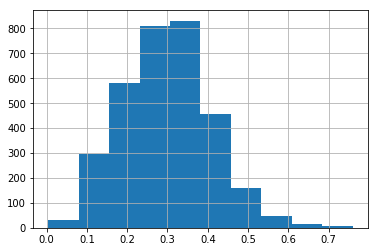

In [104]:
top_results.score_correctly_predicted.hist()

In [22]:
def get_paper_info(datadir):
    g = glob(os.path.join(datadir, '..', '*paperinfo.json'))
    if len(g) != 1:
        raise RuntimeError("failed to find paper info")
    return pd.read_json(os.path.join(g[0]), typ='series')

In [26]:
start = timer()
data = []
for id, row in top_results.iterrows():
    # this_row_data = get_paper_info(row.datadir)
    this_row_data = get_paper_info(os.path.join('..', row.datadir))
    this_row_data['id'] = id
    data.append(this_row_data)
paperinfo = pd.DataFrame(data).set_index('id')
print(format_timespan(timer()-start))

2 minutes and 37.23 seconds


In [84]:
row.datadir

'data/review_2019639629/seed_004'

In [86]:
os.listdir(os.path.join('..' , row.datadir))

['target_papers.pickle',
 'test_papers.pickle',
 'test_papers_checkpoint.pickle',
 'experiments_featuresAvgDistanceAndEFAndAvgCosSim_20180709101624.log',
 'counter_checkpoint.pickle',
 'best_model_20180709101637274357',
 'best_model_20180709101636733979',
 'seed_papers.pickle',
 'counter.pickle',
 'experiments_featuresAvgDistanceAndEF_20180709101624.log']

In [177]:
paperinfo

,wos_id,mag_id,doi,wos_date,wos_title,wos_title_source,wos_num_citations,mag_date,mag_title,mag_EF,multiple_match_flag
id,,,,,,,,,,,
90602,WOS:000243341400002,2071171979,10.1016/j.paerosci.2006.10.001,2006-05-01,Wing-in-ground effect vehicles,PROGRESS IN AEROSPACE SCIENCES,770,1146441600000,wing in ground effect vehicles,6.930000e-08,0
90666,WOS:000243341400002,2071171979,10.1016/j.paerosci.2006.10.001,2006-05-01,Wing-in-ground effect vehicles,PROGRESS IN AEROSPACE SCIENCES,770,1146441600000,wing in ground effect vehicles,6.930000e-08,0
90688,WOS:000243341400002,2071171979,10.1016/j.paerosci.2006.10.001,2006-05-01,Wing-in-ground effect vehicles,PROGRESS IN AEROSPACE SCIENCES,770,1146441600000,wing in ground effect vehicles,6.930000e-08,0
42194,WOS:000357722400002,783250631,10.1093/jisesa/iev053,2015-07-01,A Coffee Berry Borer (Coleoptera: Curculionida...,JOURNAL OF INSECT SCIENCE,1854,1420070400000,a coffee berry borer coleoptera curculionidae ...,5.800000e-09,0
41355,WOS:000357722400002,783250631,10.1093/jisesa/iev053,2015-07-01,A Coffee Berry Borer (Coleoptera: Curculionida...,JOURNAL OF INSECT SCIENCE,1854,1420070400000,a coffee berry borer coleoptera curculionidae ...,5.800000e-09,0
42175,WOS:000357722400002,783250631,10.1093/jisesa/iev053,2015-07-01,A Coffee Berry Borer (Coleoptera: Curculionida...,JOURNAL OF INSECT SCIENCE,1854,1420070400000,a coffee berry borer coleoptera curculionidae ...,5.800000e-09,0
42164,WOS:000357722400002,783250631,10.1093/jisesa/iev053,2015-07-01,A Coffee Berry Borer (Coleoptera: Curculionida...,JOURNAL OF INSECT SCIENCE,1854,1420070400000,a coffee berry borer coleoptera curculionidae ...,5.800000e-09,0
72154,WOS:000284134300006,2026986848,10.1021/cr900356p,2010-11-01,Dye-Sensitized Solar Cells,CHEMICAL REVIEWS,879,1289347200000,dye sensitized solar cells,1.069500e-06,0
90641,WOS:000243341400002,2071171979,10.1016/j.paerosci.2006.10.001,2006-05-01,Wing-in-ground effect vehicles,PROGRESS IN AEROSPACE SCIENCES,770,1146441600000,wing in ground effect vehicles,6.930000e-08,0


In [27]:
row

datetime_added                                             2018-07-09 10:16:32
review_paper_id                                                     2019639629
random_seed                                                                  4
datadir                                        data/review_2019639629/seed_004
num_correctly_predicted                                                      3
num_target_papers                                                          732
num_target_in_candidates                                                     4
num_seed_papers                                                             50
score_correctly_predicted                                           0.00409836
num_candidates                                                           29811
features                     ['avg_distance_to_train', 'ef', 'avg_title_tfi...
clf                          LogisticRegression(C=1.0, class_weight='balanc...
clf_type                                            

In [56]:
top_results = top_results.join(paperinfo[['wos_title', 'mag_EF', 'doi', 'wos_title_source', 'wos_date', 'wos_num_citations', 'mag_EF']])

In [181]:
top_results.drop_duplicates('review_paper_id').wos_title.head(50).tolist()

['Wing-in-ground effect vehicles',
 'A Coffee Berry Borer (Coleoptera: Curculionidae: Scolytinae) Bibliography',
 'Dye-Sensitized Solar Cells',
 'Molecular imprinting science and technology: a survey of the literature for the years up to and including 2003',
 'Pituitary Adenylate Cyclase-Activating Polypeptide and Its Receptors: 20 Years after the Discovery',
 'Which method is best for the induction of labour? A systematic review, network meta-analysis and cost-effectiveness analysis',
 'Meliaceous Limonoids: Chemistry and Biological Activities',
 'Structure and function of the vomeronasal system: an update',
 'Surface chemistry of atomic layer deposition: A case study for the trimethylaluminum/water process',
 'Photochromism of Diarylethene Molecules and Crystals: Memories, Switches, and Actuators',
 'Physiology, Signaling, and Pharmacology of Galanin Peptides and Receptors: Three Decades of Emerging Diversity',
 'Molecular imprinting science and technology: a survey of the literature

In [183]:
top_results.drop_duplicates('review_paper_id').wos_title.tail(200).tolist()

['Flavor physics in the quark sector',
 'Structure and dynamics of molecular networks: A novel paradigm of drug discovery A comprehensive review',
 'Atmospheric composition change - global and regional air quality',
 'Short fundamental equations of state for 20 industrial fluids',
 'Human prostate cancer risk factors',
 'Physiology and pathophysiology of potassium channels in gastrointestinal epithelia',
 'Templated Techniques for the Synthesis and Assembly of Plasmonic Nanostructures',
 'Measuring atmospheric composition change',
 'Multiphase Chemistry at the Atmosphere-Biosphere Interface Influencing Climate and Public Health in the Anthropocene',
 'Pathogenesis of Human Enterovirulent Bacteria: Lessons from Cultured, Fully Differentiated Human Colon Cancer Cell Lines',
 'Diabetic cardiomyopathy: Mechanisms and new treatment strategies targeting antioxidant signaling pathways',
 'More Sustainable Approaches for the Synthesis of N-Based Heterocycles',
 'Molecular, endocrine, and genet

In [62]:
top_results['wos_date'] = pd.to_datetime(top_results.wos_date)
top_results['wos_year'] = top_results.wos_date.apply(lambda x: x.year)

In [30]:
wos_source = pd.read_table('../data/wos_title_sources_subjects.tsv')

/home/jporteno/code/autoreview/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [31]:
gb = wos_source.groupby('title_source')
wos_source['num_entries'] = wos_source.title_source.map(gb.title_source.count())

In [32]:
wos_source.sort_values(['num_entries', 'title_source'], ascending=[False, True])

,title_source,title_source_abbrev,subject_extended,subject_traditional,heading,subheading,num_entries
23655,ARTIFICIAL INTELLIGENCE IN EDUCATION,FR ART INT,Computer Science,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23656,ARTIFICIAL INTELLIGENCE IN EDUCATION,FR ART INT,Computer Science,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23657,ARTIFICIAL INTELLIGENCE IN EDUCATION,FR ART INT,Computer Science; Education & Educational Rese...,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23658,ARTIFICIAL INTELLIGENCE IN EDUCATION,FR ART INT,Computer Science; Education & Educational Rese...,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23659,ARTIFICIAL INTELLIGENCE IN EDUCATION,FRONT ARTIF INTEL AP,Computer Science,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23660,ARTIFICIAL INTELLIGENCE IN EDUCATION,FRONT ARTIF INTEL AP,Computer Science,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23661,ARTIFICIAL INTELLIGENCE IN EDUCATION,FRONT ARTIF INTEL AP,Computer Science; Education & Educational Rese...,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23662,ARTIFICIAL INTELLIGENCE IN EDUCATION,FRONT ARTIF INTEL AP,Computer Science; Education & Educational Rese...,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
23663,ARTIFICIAL INTELLIGENCE IN EDUCATION,LECT NOTES ARTIF INT,Computer Science,"Computer Science, Artificial Intelligence; Com...",Science & Technology,Technology,9.0
73902,HIGH PERFORMANCE COMPUTING SYSTEMS AND APPLICA...,NaN,Computer Science,"Computer Science, Interdisciplinary Applicatio...",Science & Technology,Technology,9.0


In [33]:
wos_source.nunique()

title_source           164411
title_source_abbrev     31732
subject_extended        11638
subject_traditional     20956
heading                     3
subheading                  3
num_entries                 9
dtype: int64

In [34]:
wos_source[['title_source', 'heading', 'subheading', 'num_entries']].drop_duplicates()

,title_source,heading,subheading,num_entries
0,NaN,NaN,NaN,NaN
1,'92 ELECTROWEAK INTERACTIONS AND UNIFIED THEORIES,Science & Technology,Physical Sciences,1.0
2,'93 ELECTROWEAK INTERACTIONS AND UNIFIED THEORIES,Science & Technology,Physical Sciences,1.0
3,'94 ELECTROWEAK INTERACTIONS AND UNIFIED THEORIES,Science & Technology,Physical Sciences,1.0
4,'95 ELECTROWEAK INTERACTIONS AND UNIFIED THEORIES,Science & Technology,Physical Sciences,1.0
5,'95 QCD AND HIGH ENERGY HADRONIC INTERACTIONS,Science & Technology,Physical Sciences,1.0
6,"'96 CHINA-JAPAN SYMPOSIUM ON PARTICUOLOGY, PRO...",Science & Technology,Technology,1.0
7,'97 NANJING INTERNATIONAL SYMPOSIUM ON HIGH YI...,Science & Technology,Technology,1.0
8,'99 INTERNATIONAL CONFERENCE ON MANAGEMENT SCI...,Science & Technology,Technology,1.0
9,'ABBASID STUDIES,Arts & Humanities,NaN,1.0


In [64]:
top_results = top_results.merge(wos_source.drop_duplicates(subset=['title_source']), how='left', left_on='wos_title_source', right_on='title_source')

In [65]:
x = top_results.drop_duplicates('review_paper_id').dropna(subset=['heading']).reset_index()
x[x.heading=="Science & Technology"]

,index,datetime_added,review_paper_id,random_seed,datadir,num_correctly_predicted,num_target_papers,num_target_in_candidates,num_seed_papers,score_correctly_predicted,...,wos_num_citations,mag_EF,wos_year,title_source,title_source_abbrev,subject_extended,subject_traditional,heading,subheading,num_entries
0,0,2018-07-07 04:42:46,2071171979,5,data/review_2071171979/seed_005,79,104,103,50,0.759615,...,770,6.930000e-08,2006,PROGRESS IN AEROSPACE SCIENCES,PROG AEROSP SCI,Engineering,"Engineering, Aerospace",Science & Technology,Technology,1.0
1,3,2018-06-26 23:22:32,783250631,2,data/review_783250631/seed_002,292,413,404,50,0.707022,...,1854,5.800000e-09,2015,JOURNAL OF INSECT SCIENCE,J INSECT SCI,Entomology,Entomology,Science & Technology,Life Sciences & Biomedicine,1.0
2,7,2018-07-03 04:55:32,2026986848,1,data/review_2026986848/seed_001,18,26,24,50,0.692308,...,879,1.069500e-06,2010,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0
3,11,2018-06-27 19:10:58,2031246464,3,data/review_2031246464/seed_003,841,1273,1256,50,0.660644,...,1498,1.568000e-07,2006,JOURNAL OF MOLECULAR RECOGNITION,J MOL RECOGNIT,Biochemistry & Molecular Biology; Biophysics,Biochemistry & Molecular Biology; Biophysics,Science & Technology,Life Sciences & Biomedicine,1.0
4,12,2018-06-28 04:07:17,2156979070,4,data/review_2156979070/seed_004,880,1335,1328,50,0.659176,...,1389,6.520000e-08,2009,PHARMACOLOGICAL REVIEWS,PHARMACOL REV,Pharmacology & Pharmacy,Pharmacology & Pharmacy,Science & Technology,Life Sciences & Biomedicine,1.0
5,21,2018-07-01 20:59:23,2513883627,5,data/review_2513883627/seed_005,409,653,649,50,0.626340,...,953,7.300000e-09,2016,HEALTH TECHNOLOGY ASSESSMENT,HEALTH TECHNOL ASSES,Health Care Sciences & Services,Health Care Sciences & Services,Science & Technology,Life Sciences & Biomedicine,1.0
6,23,2018-07-01 10:34:47,2334595206,1,data/review_2334595206/seed_001,413,681,677,50,0.606461,...,985,5.310000e-08,2011,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0
7,25,2018-07-07 01:31:13,2087588672,5,data/review_2087588672/seed_005,419,697,693,50,0.601148,...,773,7.820000e-08,2003,PROGRESS IN NEUROBIOLOGY,PROG NEUROBIOL,Neurosciences & Neurology,Neurosciences,Science & Technology,Life Sciences & Biomedicine,1.0
8,26,2018-06-29 04:52:11,1995191254,4,data/review_1995191254/seed_004,593,989,986,50,0.599596,...,1219,4.328000e-07,2005,JOURNAL OF APPLIED PHYSICS,J APPL PHYS,Physics,"Physics, Applied",Science & Technology,Physical Sciences,1.0
9,29,2018-07-02 02:27:39,2321077391,3,data/review_2321077391/seed_003,498,832,832,50,0.598558,...,941,6.590000e-08,2014,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0


In [66]:
x = top_results.drop_duplicates('review_paper_id')
x[x.heading.isna()]

,datetime_added,review_paper_id,random_seed,datadir,num_correctly_predicted,num_target_papers,num_target_in_candidates,num_seed_papers,score_correctly_predicted,num_candidates,...,wos_num_citations,mag_EF,wos_year,title_source,title_source_abbrev,subject_extended,subject_traditional,heading,subheading,num_entries
293,2018-07-08 12:28:04,1973613674,5,data/review_1973613674/seed_005,292,661,660,50,0.441755,232032,...,743,1.280000e-08,2011,JOURNAL OF VISION,J VISION,NaN,NaN,NaN,NaN,2.0
1001,2018-07-09 10:33:56,2103258766,2,data/review_2103258766/seed_002,244,706,693,50,0.345609,152346,...,722,1.123000e-07,2008,THORAX,THORAX,NaN,NaN,NaN,NaN,2.0
1041,2018-07-04 16:16:57,2109712401,3,data/review_2109712401/seed_003,275,803,799,50,0.342466,729380,...,822,1.185200e-06,2009,CIRCULATION,CIRCULATION,NaN,NaN,NaN,NaN,2.0
1087,2018-07-03 14:26:46,1907369419,5,data/review_1907369419/seed_005,258,761,761,50,0.339028,300618,...,868,1.975000e-07,2013,JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES,J GEOPHYS RES-ATMOS,NaN,NaN,NaN,NaN,2.0
1167,2018-07-01 04:45:19,2424173776,5,data/review_2424173776/seed_005,313,939,938,50,0.333333,493682,...,1012,9.100000e-09,2016,ADVANCED ENERGY MATERIALS,ADV ENERGY MATER,NaN,NaN,NaN,NaN,2.0
1185,2018-06-28 00:16:39,2028756415,3,data/review_2028756415/seed_003,466,1404,1402,50,0.331909,591395,...,1445,3.410000e-08,2014,BMC PSYCHIATRY,BMC PSYCHIATRY,NaN,NaN,NaN,NaN,2.0
1852,2018-06-28 08:55:15,2214094658,1,data/review_2214094658/seed_001,223,807,801,50,0.276332,379946,...,1339,3.043000e-07,2005,CIRCULATION,CIRCULATION,NaN,NaN,NaN,NaN,2.0
2167,2018-07-11 09:06:22,2562634299,1,data/review_2562634299/seed_001,151,609,608,50,0.247947,804366,...,689,5.500000e-09,2016,REVIEWS OF GEOPHYSICS,REV GEOPHYS,NaN,NaN,NaN,NaN,2.0
2474,2018-07-08 00:43:28,2146960414,1,data/review_2146960414/seed_001,216,1007,955,50,0.214499,321813,...,753,3.060000e-07,2008,THORAX,THORAX,NaN,NaN,NaN,NaN,2.0


In [67]:
df.nunique()

datetime_added                4647
review_paper_id                657
random_seed                      5
datadir                       3270
num_correctly_predicted        952
num_target_papers              459
num_target_in_candidates       771
num_seed_papers                  1
score_correctly_predicted    35363
num_candidates                3265
features                         2
clf                             12
clf_type                         6
time_fit                      5248
time_predict                  2947
saved_model                   6432
dtype: int64

In [68]:
top_results.mean().apply(lambda x: format(x, 'f'))

review_paper_id              2098909654.929733
random_seed                           2.998773
num_correctly_predicted             242.833998
num_target_papers                   853.112918
num_target_in_candidates            841.709727
num_seed_papers                      50.000000
score_correctly_predicted             0.295800
num_candidates                   551742.496778
time_fit                           1739.139920
time_predict                        793.613071
mag_EF                                0.000000
mag_EF                                0.000000
wos_year                           2011.020252
num_entries                           1.079779
dtype: object

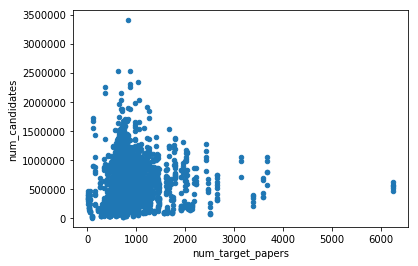

In [69]:
top_results.plot.scatter(x='num_target_papers', y='num_candidates')

(0, 1000000.0)

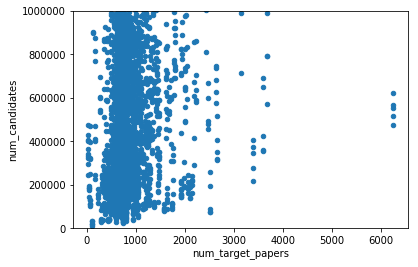

In [70]:
top_results.plot.scatter(x='num_target_papers', y='num_candidates').set_ylim(0,1e6)

In [71]:
top_results.corr()

,review_paper_id,random_seed,num_correctly_predicted,num_target_papers,num_target_in_candidates,num_seed_papers,score_correctly_predicted,num_candidates,time_fit,time_predict,mag_EF,mag_EF,wos_year,num_entries
review_paper_id,1.000000,0.000707,0.025476,0.028250,0.031453,NaN,-0.006377,0.006372,0.012162,0.010407,-0.031755,-0.031755,0.188643,-0.019579
random_seed,0.000707,1.000000,0.003428,0.003956,0.004287,NaN,0.004105,-0.007074,-0.009547,-0.010291,0.000471,0.000471,0.002299,0.000200
num_correctly_predicted,0.025476,0.003428,1.000000,0.614635,0.637955,NaN,0.524951,-0.023788,0.011538,0.048685,0.069897,0.069897,-0.008573,-0.079300
num_target_papers,0.028250,0.003956,0.614635,1.000000,0.987458,NaN,-0.188114,0.067361,0.146017,0.176866,0.020142,0.020142,-0.058269,0.057808
num_target_in_candidates,0.031453,0.004287,0.637955,0.987458,1.000000,NaN,-0.168619,0.087647,0.164141,0.198805,0.011185,0.011185,-0.053571,0.063638
num_seed_papers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score_correctly_predicted,-0.006377,0.004105,0.524951,-0.188114,-0.168619,NaN,1.000000,-0.146246,-0.159278,-0.153513,0.097537,0.097537,0.004239,-0.171904
num_candidates,0.006372,-0.007074,-0.023788,0.067361,0.087647,NaN,-0.146246,1.000000,0.812632,0.893741,-0.036220,-0.036220,0.238288,0.010161
time_fit,0.012162,-0.009547,0.011538,0.146017,0.164141,NaN,-0.159278,0.812632,1.000000,0.892391,-0.013057,-0.013057,0.179895,0.034790
time_predict,0.010407,-0.010291,0.048685,0.176866,0.198805,NaN,-0.153513,0.893741,0.892391,1.000000,-0.026410,-0.026410,0.207501,0.035729


In [40]:
num_target_not_in_candidate = top_results.num_target_papers - top_results.num_target_in_candidates
num_target_not_in_candidate.value_counts().sort_index()

0       1152
1        739
2        380
3        250
4        182
5        126
6         80
7         67
8         32
9         34
10        16
11        16
12        19
13        14
14        18
15         7
16         6
17         2
18         1
19         7
20         3
21         3
23         3
24         5
25         2
52         4
53         1
60         1
62         1
63         1
        ... 
312        2
313        1
317        1
321        1
330        2
331        3
487        1
490        1
491        1
492        2
501        1
506        2
507        1
511        1
543        1
544        2
549        1
551        1
623        1
628        1
629        1
630        1
632        1
727        4
728        1
1281       1
1283       1
1287       1
1289       1
1292       1
Length: 88, dtype: int64

In [105]:
def get_subj_ext_first(subj_ext):
    if pd.notnull(subj_ext):
        split = subj_ext.split('; ')
        return split[0]
    return None
top_results['subject_extended_first'] = top_results.subject_extended.apply(get_subj_ext_first)

/home/jporteno/code/autoreview/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
top_results.subject_extended_first.value_counts()

Chemistry                                     1045
Physiology                                     340
Physics                                        275
Biochemistry & Molecular Biology               225
Pharmacology & Pharmacy                        215
Neurosciences & Neurology                      180
Materials Science                              115
Microbiology                                    95
Endocrinology & Metabolism                      65
General & Internal Medicine                     45
Cardiovascular System & Cardiology              40
Environmental Sciences & Ecology                40
Engineering                                     35
Thermodynamics                                  30
Polymer Science                                 30
Plant Sciences                                  25
Oncology                                        25
Behavioral Sciences                             25
Life Sciences & Biomedicine - Other Topics      20
Developmental Biology          

In [107]:
top_results[top_results.subject_extended_first=='Computer Science'][['review_paper_id', 'num_target_papers', 'score_correctly_predicted', 'num_candidates', 'wos_title', 'wos_title_source', 'subject_extended']]

,review_paper_id,num_target_papers,score_correctly_predicted,num_candidates,wos_title,wos_title_source,subject_extended
811,2076063813,873,0.364261,1348977,Deep learning in neural networks: An overview,NEURAL NETWORKS,Computer Science
1181,2076063813,873,0.332188,2312499,Deep learning in neural networks: An overview,NEURAL NETWORKS,Computer Science
1193,2076063813,873,0.331042,2253791,Deep learning in neural networks: An overview,NEURAL NETWORKS,Computer Science
1264,2076063813,873,0.325315,2523591,Deep learning in neural networks: An overview,NEURAL NETWORKS,Computer Science
1265,2076063813,873,0.325315,1880183,Deep learning in neural networks: An overview,NEURAL NETWORKS,Computer Science


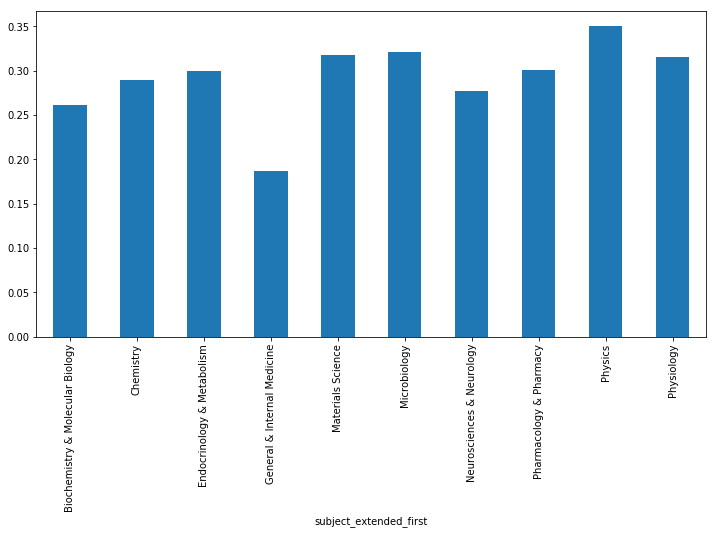

In [108]:
top10 = top_results.subject_extended_first.value_counts()[:10].index
x = top_results[top_results.subject_extended_first.isin(top10)]
gb = x.groupby('subject_extended_first')
plt.figure(figsize=(12,6))
gbmean = gb['score_correctly_predicted'].mean()
gbmean.plot.bar()

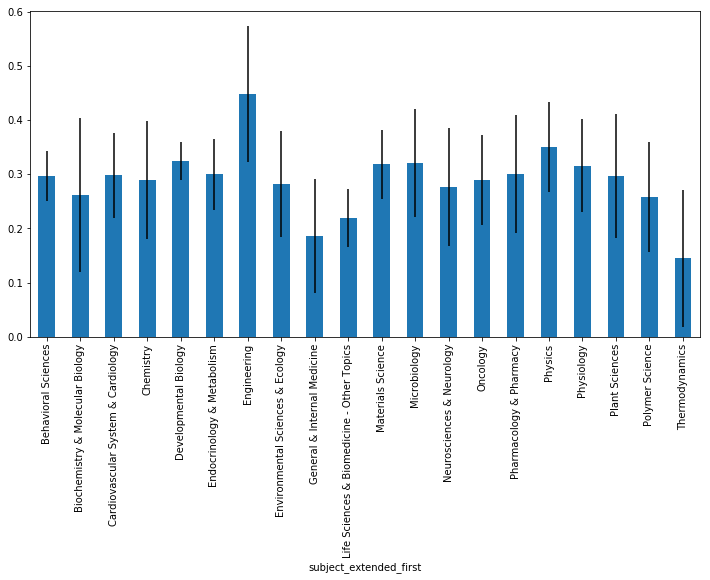

In [109]:
top20 = top_results.subject_extended_first.value_counts()[:20].index
x = top_results[top_results.subject_extended_first.isin(top20)]
gb = x.groupby('subject_extended_first')
plt.figure(figsize=(12,6))
gbmean = gb['score_correctly_predicted'].mean()
gberrs = gb['score_correctly_predicted'].std()
gbmean.plot.bar(yerr=gberrs)

In [110]:
top_results[top_results.num_target_papers>50].score_correctly_predicted.describe()

count    3225.000000
mean        0.296182
std         0.109187
min         0.004098
25%         0.219907
50%         0.297359
75%         0.363893
max         0.759615
Name: score_correctly_predicted, dtype: float64

In [125]:
subject_map = {
    'Chemistry': 'Natural Sciences',
    'Physiology': 'Medicine',
    'Physics': 'Natural Sciences',
    'Biochemistry & Molecular Biology': 'Biology',
    'Pharmacology & Pharmacy': 'Medicine',
    'Neurosciences & Neurology': 'Medicine',
    'Materials Science': 'Engineering',
    'Microbiology': 'Biology',
    'Endocrinology & Metabolism': 'Medicine',
    'General & Internal Medicine': 'Medicine',
    'Cardiovascular System & Cardiology': 'Medicine',
    'Environmental Sciences & Ecology': 'Environmental Sciences',
    'Engineering': 'Engineering',
    'Thermodynamics': 'Engineering',
    'Polymer Science': 'Engineering',
    'Oncology': 'Medicine',
    'Plant Sciences': 'Environmental Sciences',
    'Behavioral Sciences': 'Psychology and Social Sciences',
    'Life Sciences & Biomedicine - Other Topics': 'Biology',
    'Developmental Biology': 'Biology',
    'Psychology': 'Psychology and Social Sciences',
    'Geology': 'Earth Sciences',
    'Biotechnology & Applied Microbiology': 'Biology',
    'Toxicology': 'Medicine',
    'Anthropology': 'Psychology and Social Sciences',
    'Health Care Sciences & Services': 'Medicine',
    'Allergy': 'Medicine',
    'Cell Biology': 'Biology',
    'Astronomy & Astrophysics': 'Natural Sciences',
    'Ophthalmology': 'Medicine',
    'Genetics & Heredity': 'Medicine',
    'Psychiatry': 'Medicine',
    'Hematology': 'Medicine',
    'Zoology': 'Biology',
    'Fisheries': 'Environmental Sciences',
    'Entomology': 'Biology',
    'Pediatrics': 'Medicine',
    'Infectious Diseases': 'Medicine',
    'Optics': 'Natural Sciences',
    'Nutrition & Dietetics': 'Medicine',
    'Gastroenterology & Hepatology': 'Medicine',
    'Rheumatology': 'Medicine',
    'Oceanography': 'Earth Sciences',
    'Research & Experimental Medicine': 'Medicine',
    'Surgery': 'Medicine',
    'Meteorology & Atmospheric Sciences': 'Earth Sciences',
    'Anesthesiology': 'Medicine'
}

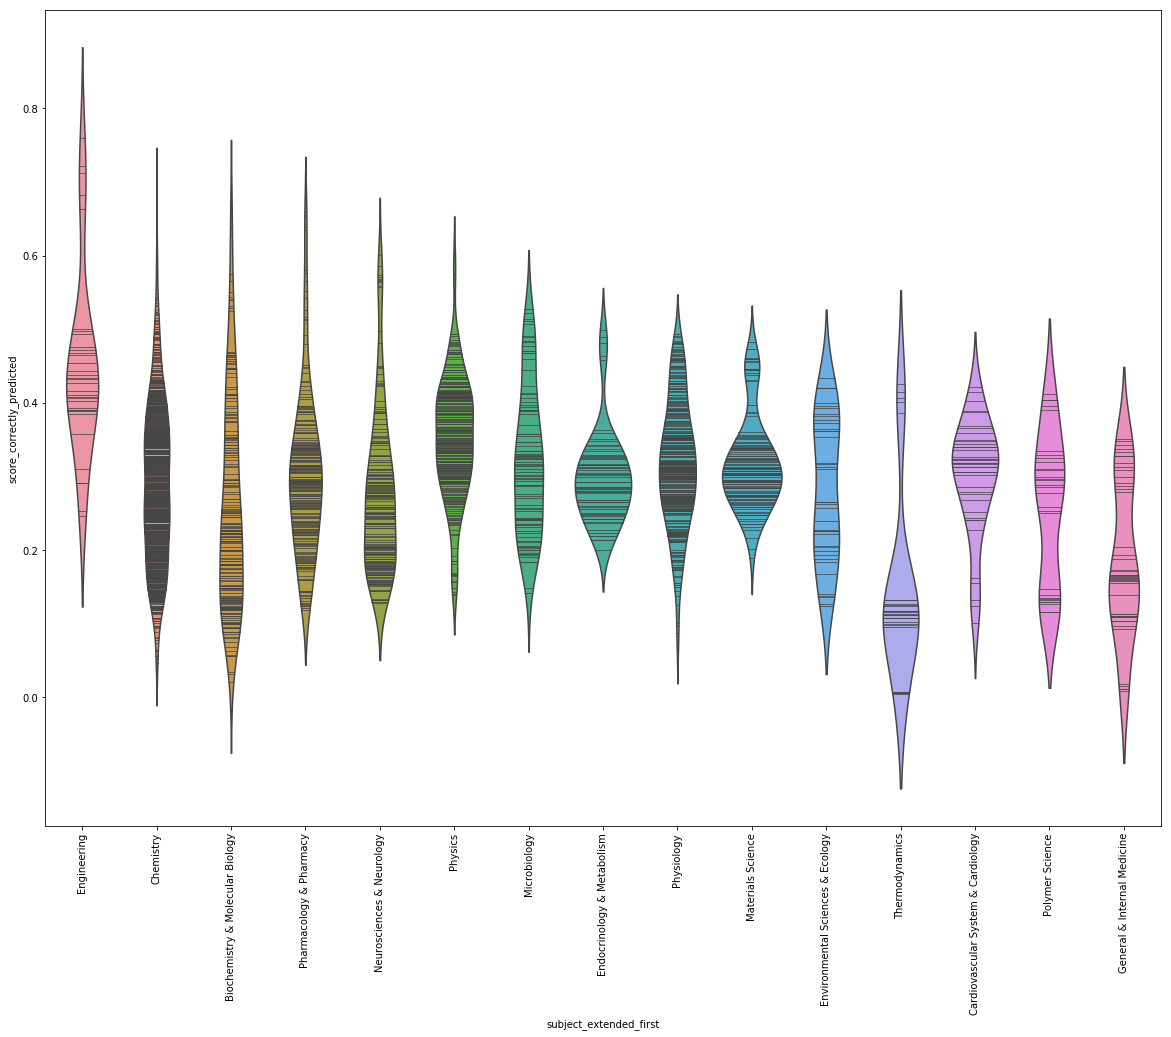

In [126]:
n = 15
topn = top_results.subject_extended_first.value_counts()[:n].index
x = top_results[top_results.subject_extended_first.isin(topn)]
fig, ax = plt.subplots(figsize=(20,15))
sns.violinplot(x=x['subject_extended_first'], y=x['score_correctly_predicted'], inner='stick', ax=ax)
ax.xaxis.set_tick_params(rotation=90)

In [127]:
_subj_mapped = top_results.subject_extended_first.map(subject_map)

In [128]:
top_results[['review_paper_id', 'title_source', 'subject_extended', 'subject_extended_first']][_subj_mapped.isna()].subject_extended_first.value_counts()

Spectroscopy                     15
Food Science & Technology        10
Energy & Fuels                   10
Agriculture                       5
Instruments & Instrumentation     5
Microscopy                        5
Biophysics                        5
Computer Science                  5
Name: subject_extended_first, dtype: int64

In [251]:
sns.color_palette('deep')[1:]

[(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

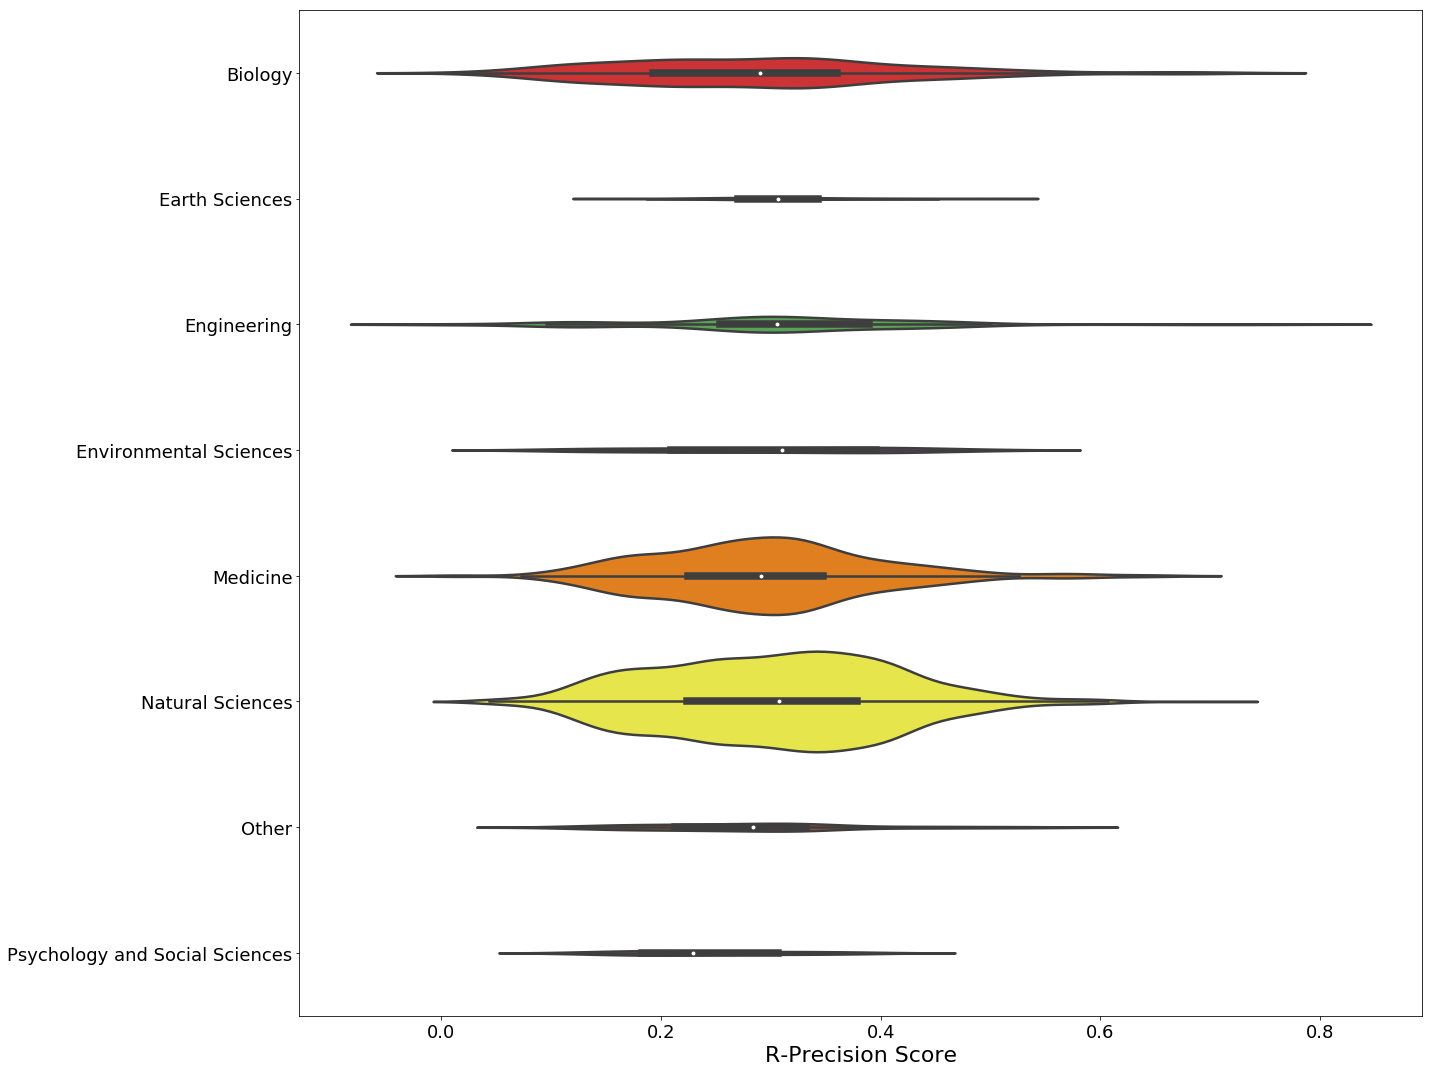

In [278]:
subj_mapped = top_results.subject_extended_first.map(subject_map).fillna(value='Other')
x = top_results.loc[subj_mapped.index]
fig, ax = plt.subplots(figsize=(20,15))
color_palette = sns.color_palette(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])

# sns.violinplot(x=subj_mapped, y=top_results['score_correctly_predicted'], scale='count', ax=ax)
sns.violinplot(x=top_results['score_correctly_predicted'], y=subj_mapped.sort_values(), palette=color_palette, orient='h', linewidth=2.5, scale='count', ax=ax)
# ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('R-Precision Score', size=22)
ax.set_ylabel('')

ax.tick_params(labelsize=18)
plt.tight_layout()

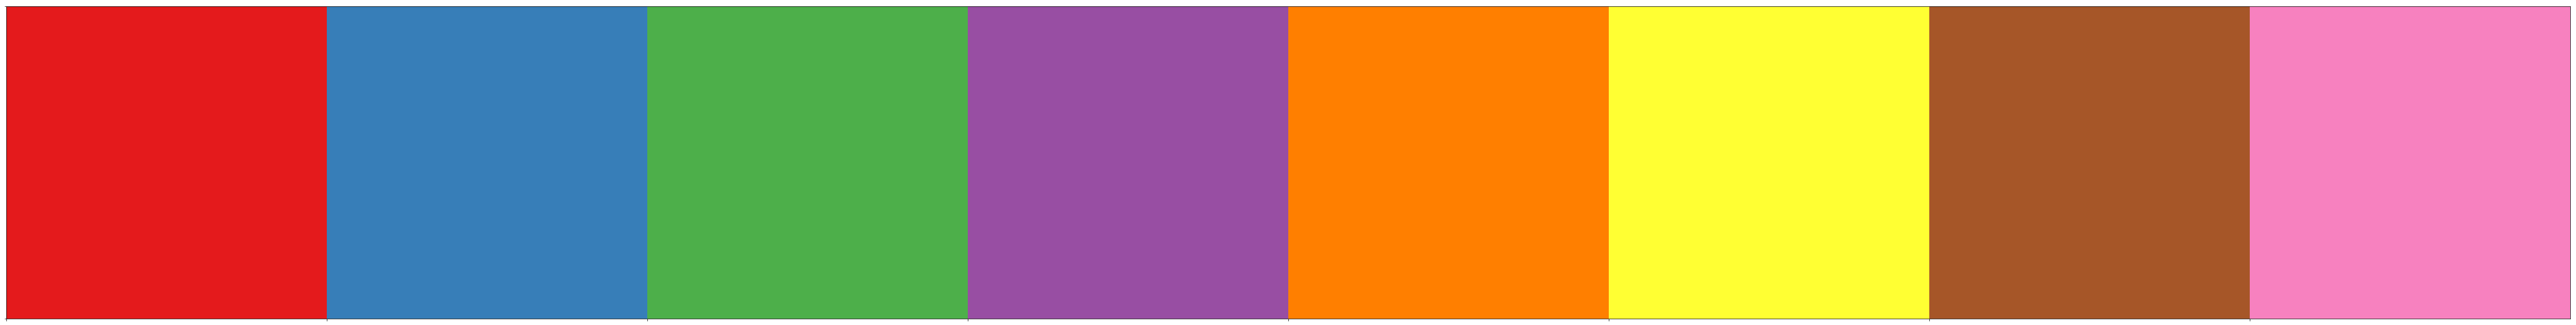

In [268]:
sns.palplot(color_palette, 10)

In [279]:
fig.savefig('score_correctly_predicted_violinplot_by_subject_20190927.png')

In [164]:
subj_mapped.value_counts()

Natural Sciences                  1335
Medicine                          1030
Biology                            400
Engineering                        210
Other                              105
Environmental Sciences              70
Psychology and Social Sciences      60
Earth Sciences                      30
Name: subject_extended_first, dtype: int64

In [167]:
top_results.score_correctly_predicted.groupby(subj_mapped).apply(np.mean)

subject_extended_first
Biology                           0.289668
Earth Sciences                    0.314920
Engineering                       0.306471
Environmental Sciences            0.301063
Medicine                          0.293026
Natural Sciences                  0.302315
Other                             0.285011
Psychology and Social Sciences    0.244872
Name: score_correctly_predicted, dtype: float64

In [141]:
top_results.score_correctly_predicted.groupby(subj_mapped).apply(list)

subject_extended_first
Biology                           [0.707022, 0.707022, 0.697337, 0.694915, 0.677...
Earth Sciences                    [0.475113, 0.452489, 0.429864, 0.409502, 0.391...
Engineering                       [0.759615, 0.721154, 0.711538, 0.682692, 0.663...
Environmental Sciences            [0.486413, 0.486413, 0.483696, 0.467391, 0.459...
Medicine                          [0.659176, 0.654682, 0.653933, 0.638951, 0.634...
Natural Sciences                  [0.692308, 0.606461, 0.599596, 0.599119, 0.599...
Other                             [0.536691, 0.535252, 0.535252, 0.529496, 0.528...
Psychology and Social Sciences    [0.398929, 0.397482, 0.375899, 0.374833, 0.370...
Name: score_correctly_predicted, dtype: object

In [144]:
from scipy.stats import f_oneway
_groups = top_results.score_correctly_predicted.groupby(subj_mapped).apply(list).values
f_oneway(*_groups)

F_onewayResult(statistic=3.3838312190404123, pvalue=0.0013291270320005934)

In [148]:
from scipy.stats import ttest_ind
ttest_ind(_groups[0], _groups[1])

Ttest_indResult(statistic=-1.035632316518496, pvalue=0.300958481016631)

In [176]:
from itertools import combinations
_groups = top_results.score_correctly_predicted.groupby(subj_mapped).apply(list)
_groups = _groups.drop('Other')
num_comparisons = len(list(combinations(_groups.index, 2)))
corrected_pval = .05/num_comparisons
print("corrected_pval: {}".format(corrected_pval))
print()
for a, b in combinations(_groups.index, 2):
    print("{} | {}".format(a, b))
    r = ttest_ind(_groups[a], _groups[b])
    print(r)
    if r.pvalue < corrected_pval:
        print("pvalue < corrected_pval")
    print()

corrected_pval: 0.002380952380952381

Biology | Earth Sciences
Ttest_indResult(statistic=-1.035632316518496, pvalue=0.300958481016631)

Biology | Engineering
Ttest_indResult(statistic=-1.5144002438279018, pvalue=0.1304440168738876)

Biology | Environmental Sciences
Ttest_indResult(statistic=-0.6801783239191762, pvalue=0.49672788217035324)

Biology | Medicine
Ttest_indResult(statistic=-0.5135287932309935, pvalue=0.6076609174411101)

Biology | Natural Sciences
Ttest_indResult(statistic=-1.959530052872041, pvalue=0.05021083230456282)

Biology | Psychology and Social Sciences
Ttest_indResult(statistic=2.5580478176900012, pvalue=0.0108469377760598)

Earth Sciences | Engineering
Ttest_indResult(statistic=0.3586722229576703, pvalue=0.7201582682594927)

Earth Sciences | Environmental Sciences
Ttest_indResult(statistic=0.6334222039165035, pvalue=0.5279334780431494)

Earth Sciences | Medicine
Ttest_indResult(statistic=1.1730479855419829, pvalue=0.24104059148989349)

Earth Sciences | Natural Scie

In [138]:
subj_mapped.value_counts()

Natural Sciences                  1335
Medicine                          1030
Biology                            400
Engineering                        210
Other                              105
Environmental Sciences              70
Psychology and Social Sciences      60
Earth Sciences                      30
Name: subject_extended_first, dtype: int64

In [56]:
top_results.columns

Index(['datetime_added', 'review_paper_id', 'random_seed', 'datadir',
       'num_correctly_predicted', 'num_target_papers',
       'num_target_in_candidates', 'num_seed_papers',
       'score_correctly_predicted', 'num_candidates', 'features', 'clf',
       'clf_type', 'time_fit', 'time_predict', 'saved_model', 'wos_title',
       'mag_EF', 'doi', 'wos_title_source', 'title_source',
       'title_source_abbrev', 'subject_extended', 'subject_traditional',
       'heading', 'subheading', 'num_entries', 'subject_extended_first'],
      dtype='object')

In [75]:
top_results.wos_title.apply(lambda x: 'review' in x.lower()).sum() / len(top_results)

0.06750536974532065

In [76]:
top_results.wos_title.apply(lambda x: 'systematic' in x.lower()).sum() / len(top_results)

0.010739490641301013

In [81]:
systematic = top_results.wos_title.apply(lambda x: 'systematic' in x.lower())
top_results[systematic].score_correctly_predicted.mean()

0.33272205714285713

In [58]:
top_results[top_results.review_paper_id==2298456115]

,datetime_added,review_paper_id,random_seed,datadir,num_correctly_predicted,num_target_papers,num_target_in_candidates,num_seed_papers,score_correctly_predicted,num_candidates,...,doi,wos_title_source,title_source,title_source_abbrev,subject_extended,subject_traditional,heading,subheading,num_entries,subject_extended_first
1584,2018-07-07 02:23:45,2298456115,2,data/review_2298456115/seed_002,198,658,658,50,0.300912,485103,...,10.1021/cr500447k,CHEMICAL REVIEWS,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0,Chemistry
1966,2018-07-07 02:30:42,2298456115,3,data/review_2298456115/seed_003,175,658,658,50,0.265957,294522,...,10.1021/cr500447k,CHEMICAL REVIEWS,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0,Chemistry
2004,2018-07-07 02:13:19,2298456115,1,data/review_2298456115/seed_001,173,658,657,50,0.262918,327398,...,10.1021/cr500447k,CHEMICAL REVIEWS,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0,Chemistry
2006,2018-07-07 02:38:27,2298456115,4,data/review_2298456115/seed_004,173,658,658,50,0.262918,344183,...,10.1021/cr500447k,CHEMICAL REVIEWS,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0,Chemistry
2328,2018-07-07 02:45:47,2298456115,5,data/review_2298456115/seed_005,152,658,657,50,0.231003,332191,...,10.1021/cr500447k,CHEMICAL REVIEWS,CHEMICAL REVIEWS,CHEM REV,Chemistry,"Chemistry, Multidisciplinary",Science & Technology,Physical Sciences,1.0,Chemistry


In [190]:
top_results.columns

Index(['datetime_added', 'review_paper_id', 'random_seed', 'datadir',
       'num_correctly_predicted', 'num_target_papers',
       'num_target_in_candidates', 'num_seed_papers',
       'score_correctly_predicted', 'num_candidates', 'features', 'clf',
       'clf_type', 'time_fit', 'time_predict', 'saved_model', 'wos_title',
       'mag_EF', 'doi', 'wos_title_source', 'wos_date', 'wos_num_citations',
       'mag_EF', 'wos_year', 'title_source', 'title_source_abbrev',
       'subject_extended', 'subject_traditional', 'heading', 'subheading',
       'num_entries', 'subject_extended_first'],
      dtype='object')

In [196]:
# average number of references in the review articles
unique_review_papers = top_results.drop_duplicates(subset=['review_paper_id'])
num_references = unique_review_papers.num_seed_papers + unique_review_papers.num_target_papers
print("number of references in review articles")
print(num_references.describe())
print("median: {}".format(num_references.median()))

number of references in review articles
count     648.000000
mean      900.479938
std       455.757087
min        76.000000
25%       692.000000
50%       775.500000
75%       986.250000
max      6296.000000
dtype: float64
median: 775.5


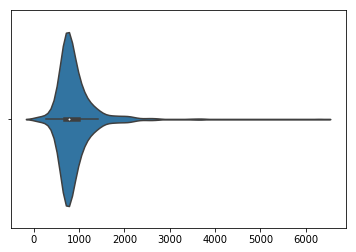

In [197]:
sns.violinplot(num_references)

In [203]:
# average year of review papers
print("review articles year of publication")
print(unique_review_papers.wos_year.describe())
print("median: {}".format(unique_review_papers.wos_year.median()))

review articles year of publication
count     648.000000
mean     2011.023148
std         3.968316
min      1997.000000
25%      2008.000000
50%      2012.000000
75%      2014.000000
max      2016.000000
Name: wos_year, dtype: float64
median: 2012.0


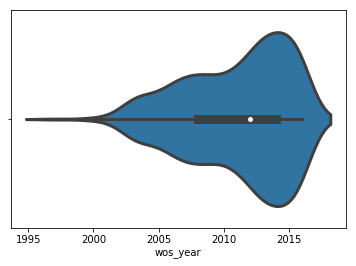

In [209]:
sns.violinplot(unique_review_papers.wos_year, linewidth=3)

In [211]:
# average number of candidates generated
print("number of candidates")
print(top_results.num_candidates.describe())
print("median: {}".format(top_results.num_candidates.median()))

number of candidates
count    3.240000e+03
mean     5.527536e+05
std      3.647322e+05
min      1.269800e+04
25%      2.542558e+05
50%      4.954180e+05
75%      7.892380e+05
max      3.408601e+06
Name: num_candidates, dtype: float64
median: 495418.0


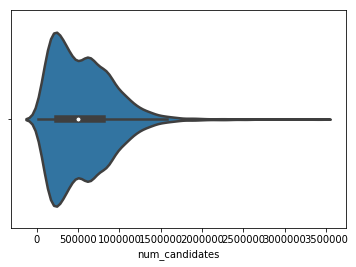

In [215]:
sns.violinplot(top_results.num_candidates, linewidth=2.5)

In [218]:
# average percentage of target papers in candidates
print("percentage of target papers in the candidate set")
ratio_target_in_candidates = top_results.num_target_in_candidates / top_results.num_target_papers
print(ratio_target_in_candidates.describe())

percentage of target papers in the candidate set
count    3240.000000
mean        0.986341
std         0.083343
min         0.005464
25%         0.995968
50%         0.998544
75%         1.000000
max         1.000000
dtype: float64


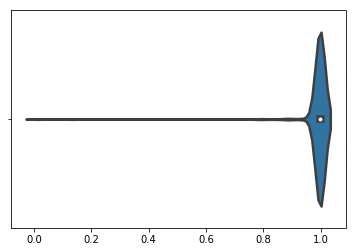

In [229]:
sns.violinplot(ratio_target_in_candidates, linewidth=2.5)

In [227]:
unique_review_papers[ratio_target_in_candidates<.8].wos_title

/home/jporteno/code/autoreview/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1689                     Proton-coupled electron transfer
2320                              Marine natural products
2544    Reduction in saturated fat intake for cardiova...
2823    School-based physical activity programs for pr...
3040    Survey of the year 2006 commercial optical bio...
3151              Thrombolysis for acute ischaemic stroke
3156    Psychosocial interventions for supporting wome...
3249              Lipid lowering efficacy of atorvastatin
3254    High-pressure fluid-phase equilibria: Experime...
Name: wos_title, dtype: object

In [298]:
def get_summary_stats(name, data):
    summary_stats = {
        'name': name,
        'min': data.min(), 
        'max': data.max(),
        'mean': data.mean(),
        'std': data.std(),
        'median': data.median()
    }
    return summary_stats

In [319]:
summary_stats = [
    get_summary_stats('Number of references', num_references),
    get_summary_stats('Publication year', unique_review_papers.wos_year),
    get_summary_stats('Number of candidates', top_results.num_candidates),
    get_summary_stats('Percentage of target in candidates', ratio_target_in_candidates*100)
]

summary_stats = pd.DataFrame.from_records(summary_stats, index='name')
# change order of columns
summary_stats = summary_stats[['min', 'max', 'mean', 'std', 'median']]
print(summary_stats.round(2).to_latex())


\begin{tabular}{lrrrrr}
\toprule
{} &       min &        max &       mean &        std &     median \\
name                               &           &            &            &            &            \\
\midrule
Number of references               &     76.00 &     6296.0 &     900.48 &     455.76 &     775.50 \\
Publication year                   &   1997.00 &     2016.0 &    2011.02 &       3.97 &    2012.00 \\
Number of candidates               &  12698.00 &  3408601.0 &  552753.56 &  364732.16 &  495418.00 \\
Percentage of target in candidates &      0.55 &      100.0 &      98.63 &       8.33 &      99.85 \\
\bottomrule
\end{tabular}

